In [1]:
from pathlib import Path
from typing import Iterable
import re
import os

import pandas as pd
import plotnine as gg


In [2]:
_ = gg.theme_set(gg.theme_classic() + gg.theme(axis_ticks=gg.element_blank()))
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
project_root_dir = Path("..")
benchmarks_dir = project_root_dir / "benchmarks"
n_benchmarks = len(list(benchmarks_dir.iterdir()))
print(f"number of benchmarks: {n_benchmarks}")


number of benchmarks: 4


In [4]:
def read_benchmark(file: Path) -> pd.DataFrame:
    return pd.read_table(file, sep="\t").assign(name=file.name.replace(file.suffix, ""))


def stan_or_pymc3(names: Iterable[str]) -> list[str]:
    return [re.findall("stan|pymc3", n)[0] for n in names]


In [5]:
benchmarks = (
    pd.concat(read_benchmark(f) for f in benchmarks_dir.iterdir())
    .reset_index(drop=True)
    .assign(model=lambda d: stan_or_pymc3(d.name))
)
benchmarks.head()


,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,name,model
0,148.3847,0:02:28,-,-,-,-,-,-,0.0,0,simple-pymc3-medium,pymc3
1,40.7094,0:00:40,-,-,-,-,-,-,0.0,0,simple-pymc3-medium,pymc3
2,40.7816,0:00:40,-,-,-,-,-,-,0.0,0,simple-pymc3-medium,pymc3
3,41.4171,0:00:41,-,-,-,-,-,-,0.0,0,simple-pymc3-medium,pymc3
4,8.0607,0:00:08,-,-,-,-,-,-,0.0,0,simple-stan-small,stan


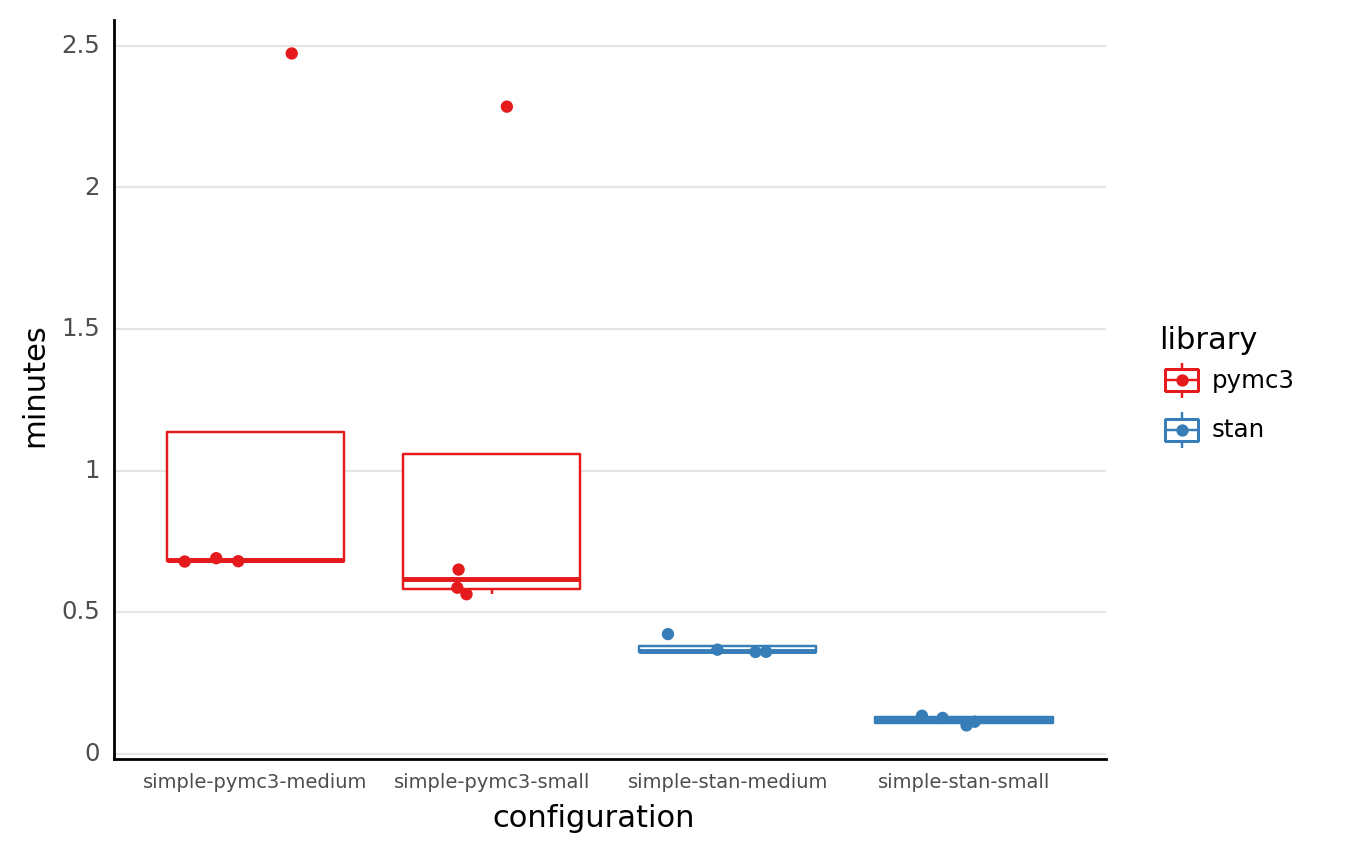

<ggplot: (341314548)>

In [6]:
(
    gg.ggplot(benchmarks, gg.aes(x="name", y="s/60", color="model"))
    + gg.geom_boxplot(outlier_alpha=0)
    + gg.geom_jitter(width=0.3)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(
        panel_grid_major_y=gg.element_line(), axis_text_x=gg.element_text(size=7)
    )
    + gg.labs(x="configuration", y="minutes", color="library")
)


In [7]:
def read_file_sizes(dir: Path) -> pd.DataFrame:
    files = list(dir.iterdir())
    sizes = pd.Series([os.path.getsize(f) for f in files])
    sizes_mb = sizes / 1000000.0
    return pd.DataFrame(
        {
            "file": files,
            "name": [f.name.replace(f.suffix, "") for f in files],
            "bytes": sizes,
            "mb": sizes_mb,
        }
    )


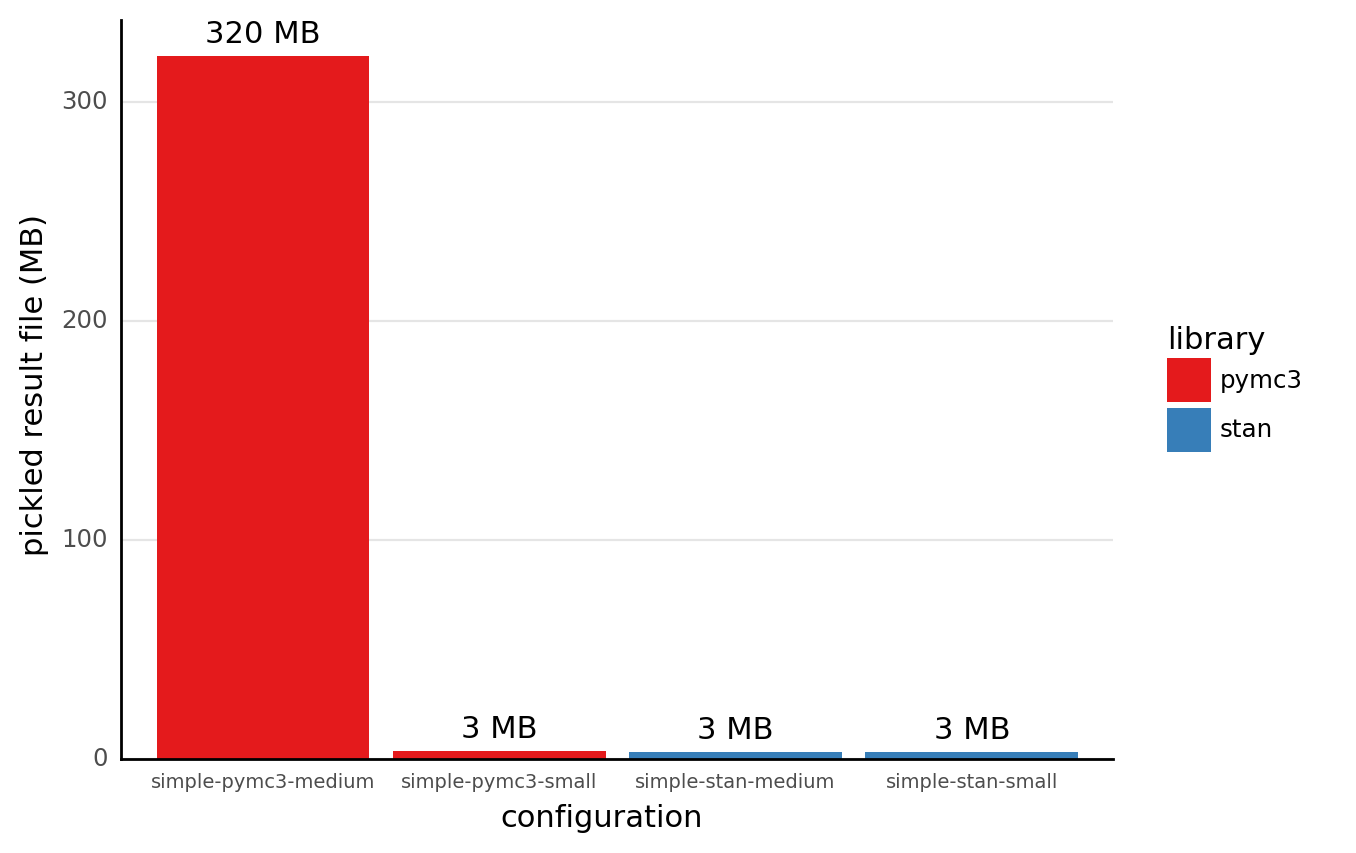

<ggplot: (341454589)>

In [8]:
result_file_sizes = read_file_sizes(project_root_dir / "model-results").assign(
    model=lambda d: stan_or_pymc3(d.name), mb_lbl = lambda d: [f"{int(x)} MB" for x in d.mb]
)

(
    gg.ggplot(result_file_sizes, gg.aes(x="name", y="mb", fill="model"))
    + gg.geom_col()
    + gg.geom_text(gg.aes(label="mb_lbl"), nudge_y=10)
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0), limits=(0, None))
    + gg.theme(
        panel_grid_major_y=gg.element_line(), axis_text_x=gg.element_text(size=7)
    )
    + gg.labs(x="configuration", y="pickled result file (MB)", fill="library")
)
